# Exploring the Effects of Home Court Advantage in the NBA

## Organisation of Notebook

### Section 1: Problem Description, Goals, Motivations

Here, we describe the problem, our motivations and goals for carrying out this data science project.

### Section 2: Data Preparation and Cleaning

Here, we import dataset, clean the data and clean dataframes, to extract the relevant information.

### Section 3: Exploratory Data Analysis

Using the cleaned dataset, we analyse and visualise the data obtained using relevant plots and diagrams.

### Section 4: Model Training with Machine Learning

We will use linear regression to train our model to predict W/L, with an emphasis on the factors that we predict affects home court advantage.

### Section 5: Discussion of Results

We will discuss the results of our model in this section.

# Section 1: Problem Description, Goals, Motivations

## Problem Description

Home court advantage is a well-documented phenomenon in the NBA, where teams playing on their home court tend to have a significantly higher win percentage compared to playing on the road. This advantage raises intriguing questions about the factors that contribute to this statistical difference and how they might influence the outcome of NBA games and series.

## Possible reasons behind the Home Court Advantage

### Crowd support and noise
The energy and support of a home crowd can provide a significant adrenaline boost for players, potentially enhancing their performance. Conversely, boos and distractions from an away crowd can negatively impact composure and focus, hindering optimal execution. We will be using the **arena capacity** and **audience numbers** as a proxy for this measure.

### Officiating
Subconscious bias may exist among referees due to the pressure of a roaring home crowd. Calls requiring more judgment (such as blocking vs. charging) tend to favor the home team. This leads to discrepancies in free throws and turnovers awarded, which significantly impacts the results of a game. However, this is hard to quantify, so we will omit it from our current discussion.

### Familiarity with the environment
Players gain a distinct advantage from being intimately familiar with their home court, including subtle variations in lighting, sightlines, and the court itself. Particularly, we wish to further explore how **altitude of certain arenas**, which may adversely affect the stamina of visiting teams unaccustomed to the conditions, play a role in the home court advantage.

### Travel Fatigue
The NBA's demanding travel schedule puts significant strain on players, with long flights, unfamiliar hotels, and disrupted sleep routines. The league tries to reduce travel, but often at the cost of more back-to-back games, which exhaust players further.  Research indicates this fatigue contributes to home teams outscoring visitors by an average of 0.31 points (out of 3.24). We will use variables like **difference in travel distance** to account for this element.

## Resources Referenced
- http://economics-files.pomona.edu/garysmith/econ190/Econ190%202021/ChangRan.pdf
- https://jyduan-8715.medium.com/exploratory-data-analysis-of-home-team-advantage-in-the-nba-2004-2020-58c9922a8744
- https://digitalcommons.iwu.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1412&context=parkplace



# Section 2: Data Preparation and Cleaning

### Dataset used

We are using the public Kaggle dataset [("**NBA Database**") ](https://www.kaggle.com/datasets/wyattowalsh/basketball)

### 2.1 Importing the Dataset

In [ ]:
import pandas as pd

# We want to see ALL columns in the dataset to pick the ones I need
pd.set_option('display.max_columns', None)

# Game information
game_df = pd.read_csv('/assets/game.csv', parse_dates=['game_date'])

# Attendance
game_info_df = pd.read_csv('/assets/game_info.csv', parse_dates=['game_date'])

# Arena location and Capacity
team_details_df = pd.read_csv('/assets/team_details.csv')

### 2.2 Data Cleaning


**Looking at the data that we are working with**

Unfortunately, some of the data is unavailable in the older season records. Hence, we will be analyzing recent years' data. Before we start analyzing, we need to first clean our data to remove unnecessary information that we will not be using.

In [2]:
game_df.drop(["fgm_home", "fga_home", "fg3m_home", "fg3a_home", "fg3_pct_home", "ftm_home", "fta_home", "ft_pct_home", "oreb_home", "dreb_home",
                  "reb_home", "ast_home", "stl_home", "blk_home", "tov_home", "pf_home", "plus_minus_home", "video_available_home", "wl_away", "fgm_away", "fga_away",
                  "fg3m_away", "fg3a_away", "fg3_pct_away", "ftm_away", "fta_away", "ft_pct_away", "oreb_away", "dreb_away", "reb_away", "ast_away", "stl_away",
                  "blk_away", "tov_away", "pf_away", "plus_minus_away", "video_available_away", 'min', 'fg_pct_home', 'matchup_away', 'fg_pct_away'], axis=1, inplace=True)

In [3]:
if "facebook" in team_details_df.columns:
  team_details_df.drop(["facebook", "instagram", "dleagueaffiliation", "headcoach", "owner", "generalmanager", "twitter", "yearfounded"], axis=1, inplace=True)

In [4]:
# Teams without arena capacity details

team_details_df[team_details_df['arenacapacity'].isna()]

,team_id,abbreviation,nickname,city,arena,arenacapacity
3,1610612743,DEN,Nuggets,Denver,Ball Arena,NaN
4,1610612744,GSW,Warriors,Golden State,Chase Center,NaN
11,1610612751,BKN,Nets,Brooklyn,Barclays Center,NaN
13,1610612755,PHI,76ers,Philadelphia,Wells Fargo Center,NaN
14,1610612756,PHX,Suns,Phoenix,Footprint Center,NaN
18,1610612760,OKC,Thunder,Oklahoma City,Paycom Center,NaN
19,1610612761,TOR,Raptors,Toronto,Scotiabank Arena,NaN
20,1610612762,UTA,Jazz,Utah,Delta Center,NaN
23,1610612765,DET,Pistons,Detroit,Little Caesars Arena,NaN


Manually finding the seating capacity for the arenas where the arena capacity is unavailable:
- Ball Arena Capacity: 21,000
- Chase Center: 18,064
- Barclays Center: 19,000
- Wells Fargo Center: 21,000
- Footprint Center: 17,071
- Paycom Center: 18,203
- Scotiabank Arena: 19,800
- Delta Center: 18,206
- Little Caesars Arena: 20,491

In [5]:
for arena, arenacapacity in [["Ball Arena", 21000], ["Chase Center", 18064], ["Barclays Center", 19000], ["Wells Fargo Center", 21000],
                             ["Footprint Center", 17071], ["Paycom Center", 18203], ["Scotiabank Arena", 19800], ["Delta Center", 18206], ["Little Caesars Arena", 20491]]:
    team_details_df.loc[team_details_df['arena'] == arena, 'arenacapacity'] = arenacapacity

We must also add five rows to the dataframe for the following missing teams: Celtics, Knicks, Cavaliers, Magic, and the Pelicans.

In [6]:
teams = [
    {
        'team_id': 1610612738,
        'abbreviation': 'BOS',
        'nickname': 'Celtics',
        'city': 'Boston',
        'arena': 'TD Garden',
        'arenacapacity': 19580,
    },
    {
        'team_id': 1610612752,
        'abbreviation': 'NYK',
        'nickname': 'Knicks',
        'city': 'New York',
        'arena': 'Madison Square Garden',
        'arenacapacity': 19500,
    },
    {
        'team_id': 1610612739,
        'abbreviation': 'CLE',
        'nickname': 'Cavaliers',
        'city': 'Cleveland',
        'arena': 'Rocket Mortgage FieldHouse',
        'arenacapacity': 19432,
    },
    {
        'team_id': 1610612753,
        'abbreviation': 'ORL',
        'nickname': 'Magic',
        'city': 'Orlando',
        'arena': 'Kia Center',
        'arenacapacity': 20000,
    },
    {
        'team_id': 1610612740,
        'abbreviation': 'NOP',
        'nickname': 'Pelicans',
        'city': 'New Orleans',
        'arena': 'Smoothie King Center',
        'arenacapacity': 17791,
    },
]

temp_df = pd.DataFrame(teams)
team_details_df = pd.concat([team_details_df, temp_df], ignore_index=True)

**Mapping the arena to the locations**

We want to map the arena to its geographic location to find out how far the visiting team has to travel to reach their destination. Another data point that we are interested in is the altitude of the arena, which might affect athlete performance

In [7]:
!pip install geopy requests


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import requests

def get_elevation(lat, long):
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()
    elevation = pd.json_normalize(r, 'results')['elevation'].values[0]
    return elevation

In [9]:
from geopy.geocoders import GeoNames

geolocator = GeoNames(username="Axemortal")

# Iterate over each city in the "city" column of team_details_df
for index, row in team_details_df.iterrows():
    # Use geocode to get the location (latitude and longitude) of the city in the US
    location = geolocator.geocode(row["city"], country="US")

    team_details_df.at[index, "longitude"] = location.longitude if location else None
    team_details_df.at[index, "latitude"] = location.latitude if location else None
    team_details_df.at[index, "altitude"] = get_elevation(location.latitude, location.longitude) if location else None

team_details_df

,team_id,abbreviation,nickname,city,arena,arenacapacity,longitude,latitude,altitude
0,1610612737,ATL,Hawks,Atlanta,State Farm Arena,18729.0,-84.38798,33.74900,336.0
1,1610612741,CHI,Bulls,Chicago,United Center,21711.0,-87.65005,41.85003,179.0
2,1610612742,DAL,Mavericks,Dallas,American Airlines Center,19200.0,-96.80667,32.78306,141.0
3,1610612743,DEN,Nuggets,Denver,Ball Arena,21000.0,-104.98470,39.73915,1617.0
4,1610612744,GSW,Warriors,Golden State,Chase Center,18064.0,-118.24368,34.05223,102.0
5,1610612745,HOU,Rockets,Houston,Toyota Center,18104.0,-95.36327,29.76328,25.0
6,1610612746,LAC,Clippers,Los Angeles,Crypto.com Arena,19060.0,-118.24368,34.05223,102.0
7,1610612747,LAL,Lakers,Los Angeles,Crypto.com Arena,19060.0,-118.24368,34.05223,102.0
8,1610612748,MIA,Heat,Miami,Kaseya Center,19600.0,-80.19366,25.77427,23.0
9,1610612749,MIL,Bucks,Milwaukee,Fiserv Forum,17500.0,-87.90647,43.03890,194.0


We want to find out the travel distance for the visiting team from their previous destination. To do that, we create a dictionary of all starting cities and ending cities and take the geodesic distance (Straight line distance on an ellipsoid) as an estimate for how long each team travelled for.

In [10]:
from geopy.distance import geodesic

distance_map = {}

for i in range(len(team_details_df)):
    city1 = (team_details_df.at[i, "latitude"], team_details_df.at[i, "longitude"])
    for j in range(i + 1, len(team_details_df)):  # Start from i+1 to avoid duplicate pairs
        city2 = (team_details_df.at[j, "latitude"], team_details_df.at[j, "longitude"])

        # Calculate the distance between the two cities using geodesic
        distance = round(geodesic(city1, city2).kilometers, 2)

        # Store the distance in the dictionary
        key = (team_details_df.at[i, "city"], team_details_df.at[j, "city"])
        distance_map[key] = distance

# Print the distance map
print(distance_map)

{('Atlanta', 'Chicago'): 943.73, ('Atlanta', 'Dallas'): 1161.31, ('Atlanta', 'Denver'): 1950.43, ('Atlanta', 'Golden State'): 3117.06, ('Atlanta', 'Houston'): 1129.03, ('Atlanta', 'Los Angeles'): 3117.06, ('Atlanta', 'Miami'): 972.35, ('Atlanta', 'Milwaukee'): 1075.77, ('Atlanta', 'Minnesota'): 1620.67, ('Atlanta', 'Brooklyn'): 1200.7, ('Atlanta', 'Indiana'): 686.39, ('Atlanta', 'Philadelphia'): 1071.64, ('Atlanta', 'Phoenix'): 2562.17, ('Atlanta', 'Portland'): 3496.95, ('Atlanta', 'Sacramento'): 3358.29, ('Atlanta', 'San Antonio'): 1420.61, ('Atlanta', 'Oklahoma City'): 1218.2, ('Atlanta', 'Toronto'): 817.53, ('Atlanta', 'Utah'): 2515.82, ('Atlanta', 'Memphis'): 542.83, ('Atlanta', 'Washington'): 872.29, ('Atlanta', 'Detroit'): 959.85, ('Atlanta', 'Charlotte'): 364.53, ('Atlanta', 'Boston'): 1507.31, ('Atlanta', 'New York'): 1201.11, ('Atlanta', 'Cleveland'): 892.33, ('Atlanta', 'Orlando'): 644.95, ('Atlanta', 'New Orleans'): 682.96, ('Chicago', 'Dallas'): 1291.16, ('Chicago', 'Denver

### 2.3 Creating a new filtered data frame for the seasons 2019-23

We'll start by analyzing regular season games only, from the most recent completed seasons as playoff formats (best of 7, seeding) can complicate the data.

In [11]:
game_df['season_type'].value_counts()

season_type
Regular Season    60192
Playoffs           3842
Pre Season         1536
All Star             65
All-Star             63
Name: count, dtype: int64

In [12]:
# Include regular season games in the relevant seasons
df_regular_season_games = game_df[game_df['season_type'].isin(['Regular Season'])]
df_regular_season_games = game_df[game_df['season_id'].isin([22019, 22020, 22021, 22022])]

# Append attendance from game_info_df
df_regular_season_games = df_regular_season_games.merge(game_info_df[['game_id', 'attendance']], on='game_id', how='left')
df_regular_season_games = df_regular_season_games.fillna(0)

df_regular_season_games.head()

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,pts_home,team_id_away,team_abbreviation_away,team_name_away,pts_away,season_type,attendance
0,22019,1610612746,LAC,LA Clippers,21900002,2019-10-22,LAC vs. LAL,W,112.0,1610612747,LAL,Los Angeles Lakers,102.0,Regular Season,19068.0
1,22019,1610612761,TOR,Toronto Raptors,21900001,2019-10-22,TOR vs. NOP,W,130.0,1610612740,NOP,New Orleans Pelicans,122.0,Regular Season,0.0
2,22019,1610612754,IND,Indiana Pacers,21900004,2019-10-23,IND vs. DET,L,110.0,1610612765,DET,Detroit Pistons,119.0,Regular Season,17923.0
3,22019,1610612748,MIA,Miami Heat,21900007,2019-10-23,MIA vs. MEM,W,120.0,1610612763,MEM,Memphis Grizzlies,101.0,Regular Season,19600.0
4,22019,1610612755,PHI,Philadelphia 76ers,21900008,2019-10-23,PHI vs. BOS,W,107.0,1610612738,BOS,Boston Celtics,93.0,Regular Season,20422.0


We will add the distance travelled for the away team, based on the assumption that visitng teams stay at their last game location after the game and travel from there to the new arena.

In [13]:
def calculate_travel_distance(current_location, destination_city, distance_map):
    """Calculates travel distance between two cities."""
    if current_location == destination_city:
        return 0

    key = (current_location, destination_city)
    if key in distance_map:
        return distance_map[key]

    key = (destination_city, current_location)
    if key in distance_map:
        return distance_map[key]

    print(f"Warning: No direct route found for {current_location} -> {destination_city}")
    return None

# Initialize team location to their home city
def reset_team_location(team_details_df):
    return team_details_df.set_index('abbreviation')['city'].to_dict()

team_current_location = reset_team_location(team_details_df)
year = 2019
df_regular_season_games['travel_distance'] = 0.0

for index, row in df_regular_season_games.iterrows():
    if row['game_date'].year > year:
        year = row['game_date'].year
        team_current_location = reset_team_location(team_details_df)
    home_team = row['team_abbreviation_home']
    away_team = row['team_abbreviation_away']
    home_city = team_details_df.loc[team_details_df['abbreviation'] == home_team, 'city'].iloc[0]

    # Calculate travel distance for away team
    travel_distance = calculate_travel_distance(team_current_location[away_team], home_city, distance_map)
    df_regular_season_games.loc[index, 'travel_distance'] = travel_distance

    # Update team locations
    team_current_location[home_team] = home_city
    team_current_location[away_team] = home_city

### 2.4 Creating aggregated data for seasons between 2019-20 and 2022-2023 (regular season)

In [14]:
#import csv with aggregated season data, containing win/loss record and point differential statistics.

season_df = pd.read_csv('season.csv')
season_df

,team_name_home,2019 w % h,2019 w % a,2019 pts diff (home),2019 pts diff(away),2020 w % h,2020 w % a,2020 pts diff (home),2020 pts diff(away),2021 w % h,2021 w % a,2021 pts diff (home),2021 pts diff(away),2022 w % h,2022 w % a,2022 pts diff (home),2022 pts diff(away),2023 w % h,2023 w % a,2023 pts diff (home),2023 pts diff(away)
0,ATL,0.412,0.182,-2.8,-13.4,0.694,0.444,6.3,-1.7,0.659,0.390,5.0,-1.9,0.585,0.415,2.2,-1.7,0.512,0.366,1.1,-5.4
1,BOS,0.722,0.611,8.2,4.4,0.583,0.417,3.0,-0.1,0.683,0.561,7.0,7.6,0.780,0.610,10.0,3.0,0.902,0.659,15.2,7.5
2,BKN,0.556,0.417,1.8,-2.9,0.778,0.556,6.4,2.5,0.488,0.585,-2.1,3.6,0.561,0.537,3.0,-1.3,0.488,0.293,1.2,-7.0
3,CHA,0.323,0.382,-5.3,-8.1,0.500,0.417,-0.1,-3.8,0.537,0.512,1.5,-0.5,0.317,0.341,-6.9,-5.5,0.268,0.244,-8.0,-12.4
4,CHI,0.412,0.258,-1.5,-4.9,0.417,0.444,-1.7,-0.1,0.659,0.463,2.4,-3.2,0.537,0.439,2.8,-0.3,0.488,0.463,-0.2,-2.8
5,CLE,0.306,0.276,-6.5,-9.6,0.361,0.250,-6.8,-10.0,0.610,0.463,4.4,-0.2,0.756,0.488,8.2,2.5,0.634,0.537,4.0,0.9
6,DAL,0.526,0.622,4.9,5.0,0.583,0.583,0.3,4.2,0.707,0.561,6.3,0.3,0.561,0.366,2.7,-2.5,0.610,0.610,3.7,0.8
7,DEN,0.703,0.556,4.2,-0.1,0.694,0.611,6.5,3.4,0.561,0.610,2.4,2.3,0.829,0.463,9.8,-3.1,0.805,0.585,9.8,0.7
8,DET,0.333,0.273,-2.1,-5.0,0.361,0.194,-3.0,-5.9,0.317,0.244,-5.1,-10.3,0.220,0.195,-6.2,-10.2,0.175,0.167,-8.1,-10.1
9,GSW,0.235,0.226,-8.7,-8.8,0.694,0.389,5.2,-3.1,0.756,0.537,9.9,1.2,0.805,0.268,8.0,-4.3,0.512,0.610,0.7,4.5


In [15]:
# Rename columns to merge with team_details_df

rename_columns = {
    'team_name_home': 'abbreviation',
    '2019 pts diff(away)': '2019 pts diff (away)',
    '2020 pts diff(away)': '2020 pts diff (away)',
    '2021 pts diff(away)': '2021 pts diff (away)',
    '2022 pts diff(away)': '2022 pts diff (away)',
    '2023 pts diff(away)': '2023 pts diff (away)'
}

season_df = season_df.rename(columns=rename_columns)
team_details_df = pd.merge(team_details_df, season_df, on='abbreviation', how='right')

In [16]:
for year in ["2019", "2020", "2021", "2022"]:
    for col in [f"{year} w % h", f"{year} w % a", f"{year} pts diff (home)", f"{year} pts diff (away)"]:
        team_details_df[col] = pd.to_numeric(team_details_df[col]) 
    team_details_df[f"{year} win % difference"] = team_details_df[f"{year} w % h"] - team_details_df[f"{year} w % a"]
    team_details_df[f"{year} points differential"] = team_details_df[f"{year} pts diff (home)"] - team_details_df[f"{year} pts diff (away)"]

team_details_df.head()

,team_id,abbreviation,nickname,city,arena,arenacapacity,longitude,latitude,altitude,2019 w % h,2019 w % a,2019 pts diff (home),2019 pts diff (away),2020 w % h,2020 w % a,2020 pts diff (home),2020 pts diff (away),2021 w % h,2021 w % a,2021 pts diff (home),2021 pts diff (away),2022 w % h,2022 w % a,2022 pts diff (home),2022 pts diff (away),2023 w % h,2023 w % a,2023 pts diff (home),2023 pts diff (away),2019 win % difference,2019 points differential,2020 win % difference,2020 points differential,2021 win % difference,2021 points differential,2022 win % difference,2022 points differential
0,1610612737,ATL,Hawks,Atlanta,State Farm Arena,18729.0,-84.38798,33.74900,336.0,0.412,0.182,-2.8,-13.4,0.694,0.444,6.3,-1.7,0.659,0.390,5.0,-1.9,0.585,0.415,2.2,-1.7,0.512,0.366,1.1,-5.4,0.230,10.6,0.250,8.0,0.269,6.9,0.170,3.9
1,1610612738,BOS,Celtics,Boston,TD Garden,19580.0,-71.05977,42.35843,27.0,0.722,0.611,8.2,4.4,0.583,0.417,3.0,-0.1,0.683,0.561,7.0,7.6,0.780,0.610,10.0,3.0,0.902,0.659,15.2,7.5,0.111,3.8,0.166,3.1,0.122,-0.6,0.170,7.0
2,1610612751,BKN,Nets,Brooklyn,Barclays Center,19000.0,-73.94958,40.65010,17.0,0.556,0.417,1.8,-2.9,0.778,0.556,6.4,2.5,0.488,0.585,-2.1,3.6,0.561,0.537,3.0,-1.3,0.488,0.293,1.2,-7.0,0.139,4.7,0.222,3.9,-0.097,-5.7,0.024,4.3
3,1610612766,CHA,Hornets,Charlotte,Spectrum Center,19026.0,-80.84313,35.22709,275.0,0.323,0.382,-5.3,-8.1,0.500,0.417,-0.1,-3.8,0.537,0.512,1.5,-0.5,0.317,0.341,-6.9,-5.5,0.268,0.244,-8.0,-12.4,-0.059,2.8,0.083,3.7,0.025,2.0,-0.024,-1.4
4,1610612741,CHI,Bulls,Chicago,United Center,21711.0,-87.65005,41.85003,179.0,0.412,0.258,-1.5,-4.9,0.417,0.444,-1.7,-0.1,0.659,0.463,2.4,-3.2,0.537,0.439,2.8,-0.3,0.488,0.463,-0.2,-2.8,0.154,3.4,-0.027,-1.6,0.196,5.6,0.098,3.1


# Section 3: Exploratory Data Analysis

## Home Court Advantage

We will measure "Home Court Advantage" using the following two metrics:

**Win/Loss (W/L) Record**: Determine the impact of playing at home by looking at the percentage of games won on a team's own court versus on the road.

**Point Differential**: Examine the average difference in points scored by a team when playing at home compared to away games. This measures how significantly playing at home impacts scoring, both for and against a team.


## 3.1 Difference in w% (Home vs Away) - 2019-23

/tmp/ipykernel_870/2972092258.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = boxplot_df, x='Year', y='Win % Difference', palette='Set2')


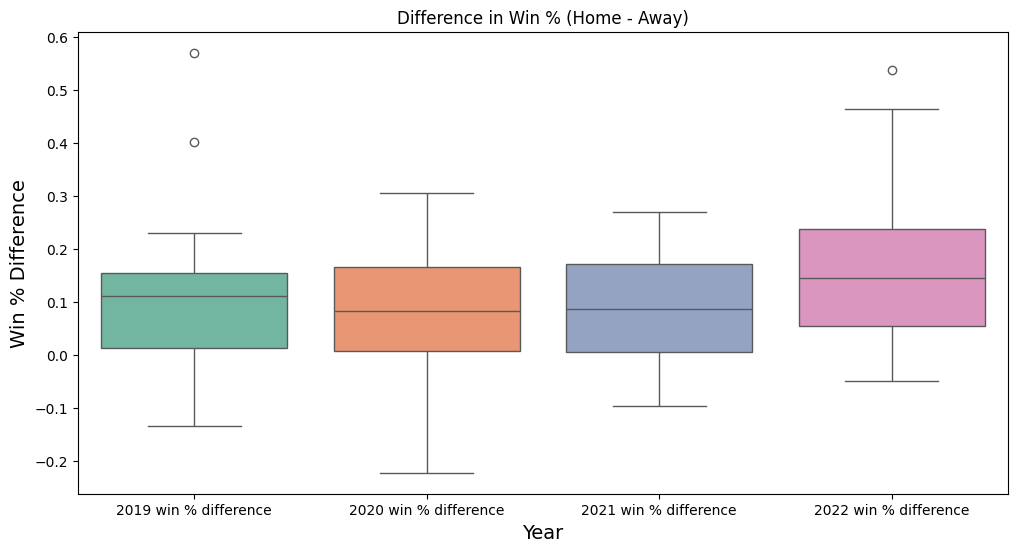

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot_df = team_details_df.melt(id_vars=['nickname'], value_vars=['2019 win % difference', '2020 win % difference', '2021 win % difference', '2022 win % difference'], var_name='Year', value_name='Win % Difference')
fig = plt.figure(figsize = (12,6))
sns.boxplot(data = boxplot_df, x='Year', y='Win % Difference', palette='Set2')
plt.title("Difference in Win % (Home - Away)")
plt.ylabel('Win % Difference',fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.show()

## 3.2 Difference in Points Difference (Home vs Away) - 2019-2023

/tmp/ipykernel_870/936985463.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = boxplot_df2, x='Year', y='Points Differential', palette='Set2')


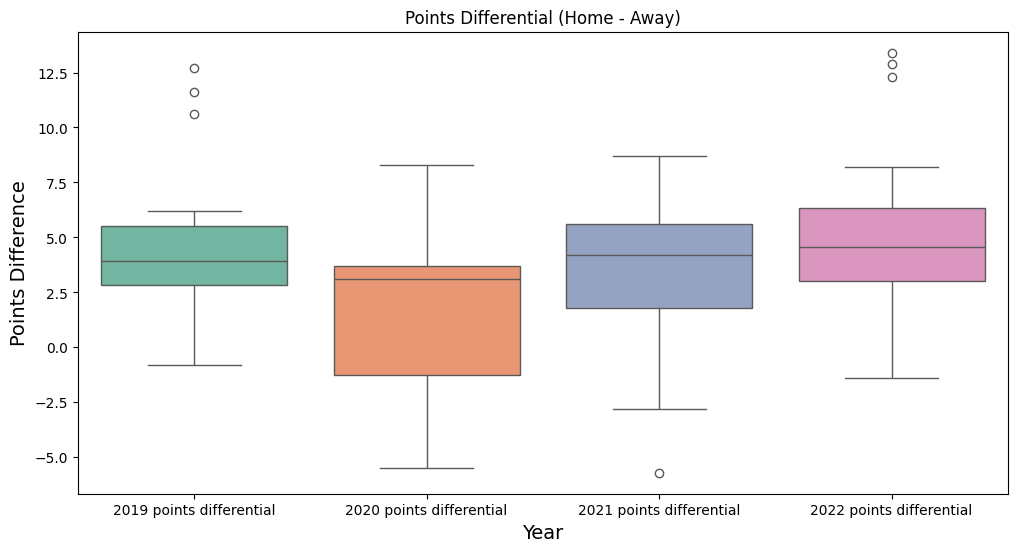

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot_df2 = team_details_df.melt(id_vars=['nickname'], value_vars=['2019 points differential', '2020 points differential', '2021 points differential', '2022 points differential'], var_name='Year', value_name='Points Differential')
fig = plt.figure(figsize = (12,6))
sns.boxplot(data = boxplot_df2, x='Year', y='Points Differential', palette='Set2')
plt.title("Points Differential (Home - Away)")
plt.ylabel('Points Difference',fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.show()

### Interpretation

(1) <ins>Difference in Win % (home win % - away win %)</ins>
The median seems to have remained fairly consistent. Crucially,we note that teams tend to have a positive win percentage difference at home compared to away, given the inter-quartile range of the values across the years lies above 0, indicating a home advantage. 

(2) <ins>Difference in Points Differential (home win % - away win %)</ins>

Except for a few outliers, the data shows a significant home advantage, because the median is between 3 and 5 points across the years. This means that teams generally outscore their opponents at home. Importantly, the 2020 graph presents a more modest advantage - which aligns with real-world happenings, when game attendance was restricted as part of NBA-wide COVID protocols.

## 3.3 Cumulative Graphs - Difference in Win % (Home-Away)                                                & Points Differential (Home - Away)  (2019-23)

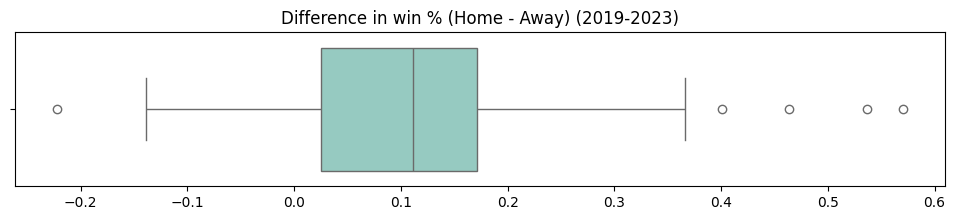

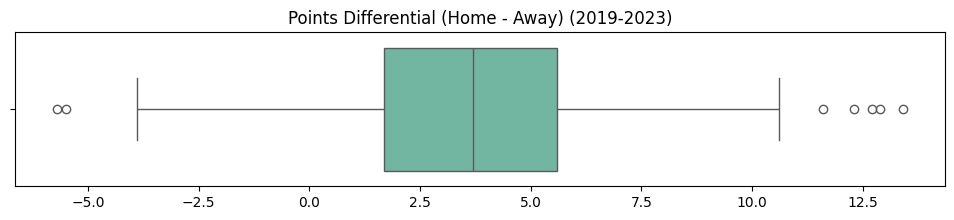

In [19]:
win_pct_data = []
points_diff_data  = []
for i, row in team_details_df.iterrows():
    nickname = row['nickname']
    for year in ['2019', '2020', '2021', '2022']:
        win_pct_data.append({'nickname': nickname, '': row[f"{year} win % difference"]})
        points_diff_data .append({'nickname': nickname, '': row[f"{year} points differential"]})

win_pct_df = pd.DataFrame(win_pct_data)
points_diff_df = pd.DataFrame(points_diff_data )

# win % across the years
fig = plt.figure(figsize = (12,2))
sns.boxplot(data = win_pct_df,palette='Set3',orient ='h')
plt.title("Difference in win % (Home - Away) (2019-2023)")
plt.show()

# point differential across the years
fig = plt.figure(figsize = (12,2))
sns.boxplot(data = points_diff_df,palette='Set2',orient ='h')
plt.title("Points Differential (Home - Away) (2019-2023)")
plt.show()

Clearly, we can see that there is a positive skewness for both points and winning % when teams play on their home court.

## 3.4 W-L (Home Team) against Altitude of Arena (2019-23)

In [20]:
if 'altitude' not in df_regular_season_games.columns:
    altitude_df = team_details_df[['altitude','abbreviation']]

    # Append altitude to main df
    df_regular_season_games = df_regular_season_games.merge(
        altitude_df,
        left_on='team_abbreviation_home',
        right_on='abbreviation',
        how='left'
    )
    df_regular_season_games.drop('abbreviation', axis=1, inplace=True)

Even though altitude is a continuous variable, we chose to model it via a bar plot because we have a finite number of different altitudes, so each arena can be modelled distinctly.

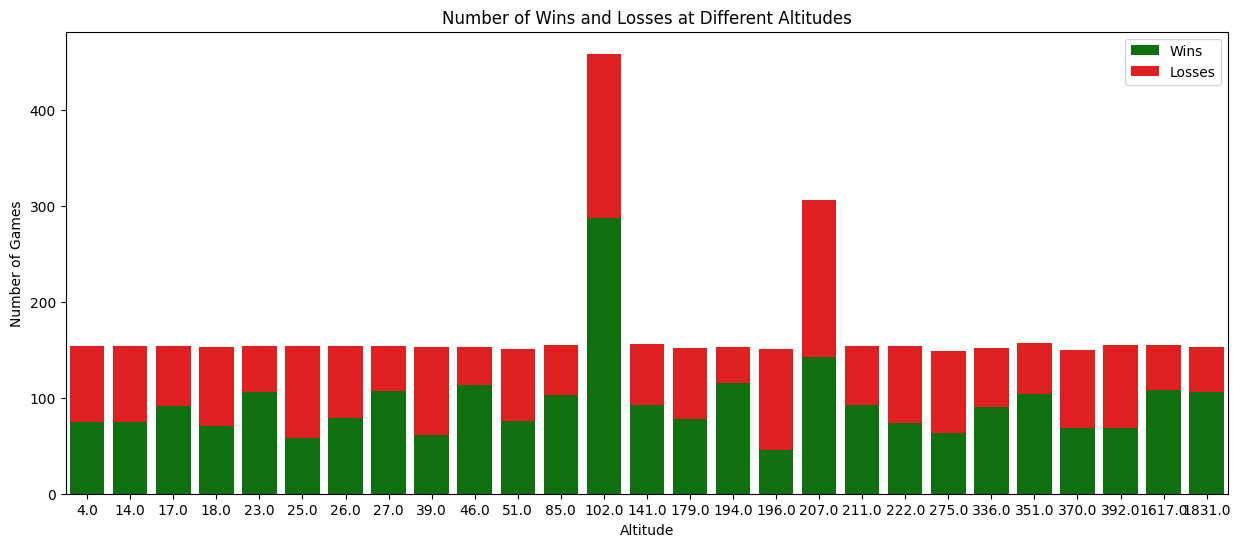

In [21]:
# Convert 'W' to 1 and 'L' to 0 for wins and losses
df_regular_season_games['win'] = (df_regular_season_games['wl_home'] == 'W').astype(int)
df_regular_season_games['loss'] = (df_regular_season_games['wl_home'] == 'L').astype(int)

# Aggregate wins and losses by altitude, calculate total games and win percentage
altitude_win_loss = df_regular_season_games.groupby('altitude').agg({
    'win': 'sum',
    'loss': 'sum'
}).assign(
    total_games=lambda x: x['win'] + x['loss'],
    win_percentage=lambda x: (x['win'] / x['total_games']) * 100
).reset_index()

# Sort by altitude
altitude_win_loss.sort_values('altitude', inplace=True)

plt.figure(figsize=(15,6))
win_bars = sns.barplot(data=altitude_win_loss, x='altitude', y='win', color='green', label='Wins')
loss_bars = sns.barplot(data=altitude_win_loss, x='altitude', y='loss', color='red', bottom=altitude_win_loss['win'], label='Losses')
plt.xlabel('Altitude')
plt.ylabel('Number of Games')
plt.title('Number of Wins and Losses at Different Altitudes')
plt.legend()
plt.show()

We see anomalies in the number of games recorded at two altitudes, 102.0 and 207.0. These are not anomalies,  as: 

(1) Altitude = 102.0 corresponds to Crypto.com arena, which is co-shared by the Los Angeles Lakers and the Los Angeles Clippers, resulting in about twice as many home games over the same period. 

(2) Altitude = 207.0, corresponds to two different arenas having the same altitude, namely the Rocket Mortgage FieldHouse in Cleveland, and the AT&T Centre in San Antonio.

**Interpretation**: Results-wise, most teams seem to enjoy more wins at home, similar to the conclusion we had in the previous boxplots. However, analysis of individual teams do not work due to the difference in the strengths of the teams.

Historically, we note that the altitude of the arena has played a part in the home advantage of the Denver Nuggets. A study conducted in 2018 on the "Mile High City" is evidence of this.

## 3.5 Win % (Home Team) against Altitude of Arena (2020-21) (Aggregated for Season)

We are only plotting one year's of data to increase the clarify of the data presentation, feel free to change the year to see the analysis of Win % against Altitude across the different years!

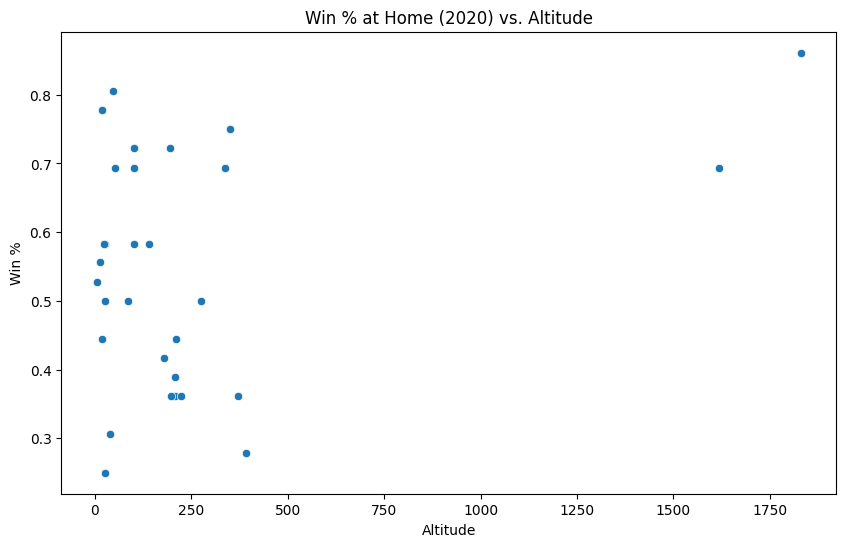

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=team_details_df, x='altitude', y='2020 w % h')
plt.xlabel('Altitude')
plt.ylabel('Win %')
plt.title('Win % at Home (2020) vs. Altitude')
plt.show()

Here, we see that when the altitude is low, teams have a varying win percentage at home. However, interestingly, the two arenas at a significantly higher altitude enjoys a rather remarkable win percentage at home.

## 3.6 Points Differential for Home Team in Wins against Fan Attendance (2019-23)

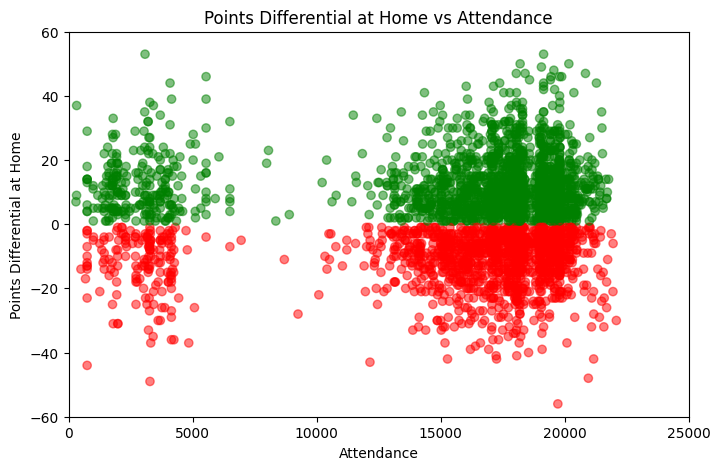

In [23]:
# Create a separate column for each game
df_regular_season_games['points differential'] = df_regular_season_games['pts_home'] - df_regular_season_games['pts_away']

# Drop rows with 0 attendance
df_home= df_regular_season_games[df_regular_season_games['attendance']!=0]
plt.figure(figsize=(8, 5))
colors = ['green' if diff > 0 else 'red' for diff in df_home['points differential']]
plt.scatter(df_home['attendance'], df_home['points differential'], alpha=0.5, color=colors)
plt.xlabel('Attendance')
plt.ylabel('Points Differential at Home')
plt.title('Points Differential at Home vs Attendance')
plt.ylim(-60, 60)
plt.xlim(0, 25000)
plt.show()

Just a cool graph to include, we cannot really conclude much about the point differential, given that there are too many data points in the graph.

# Section 4: Model Training with Machine Learning

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

## Creating the Linear Regression Model

We create a class to encapsulate the repeated logic that will be used for our linear regression analysis

In [25]:
class LinearRegressionModel:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def details(self):
        return self.model.intercept_, self.model.coef_

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = np.mean(np.square(y_test - y_pred))
        rmse = np.sqrt(mse)

        print("Explained Variance (R^2) \t:", r2)
        print("Mean Squared Error (MSE) \t:", mse)
        print("Root Mean Squared Error (RMSE) \t:", rmse)

Before we analyze, we need to further clean the data to remove outliers

In [26]:
if "arenacapacity" not in df_regular_season_games.columns:
    arena_df = team_details_df[['arenacapacity','abbreviation']]

    # Append altitude to main df
    df_regular_season_games = df_regular_season_games.merge(
        arena_df,
        left_on='team_abbreviation_home',
        right_on='abbreviation',
        how='left'
    )
    df_regular_season_games.drop('abbreviation', axis=1, inplace=True)

df_filtered = df_regular_season_games[(df_regular_season_games['attendance'] > 0) & (df_regular_season_games['attendance'] < 65000)]

win_loss = df_filtered['wl_home'].replace({'W': 1, 'L': 0}).astype(int)
points_difference = df_filtered['pts_home'] - df_filtered['pts_away']

## Univariate Analysis - W/L

Let's start with some single variate analysis to individually analyse which variables may have an effect on the win/loss and point differences of a game.

### Arena Capacity

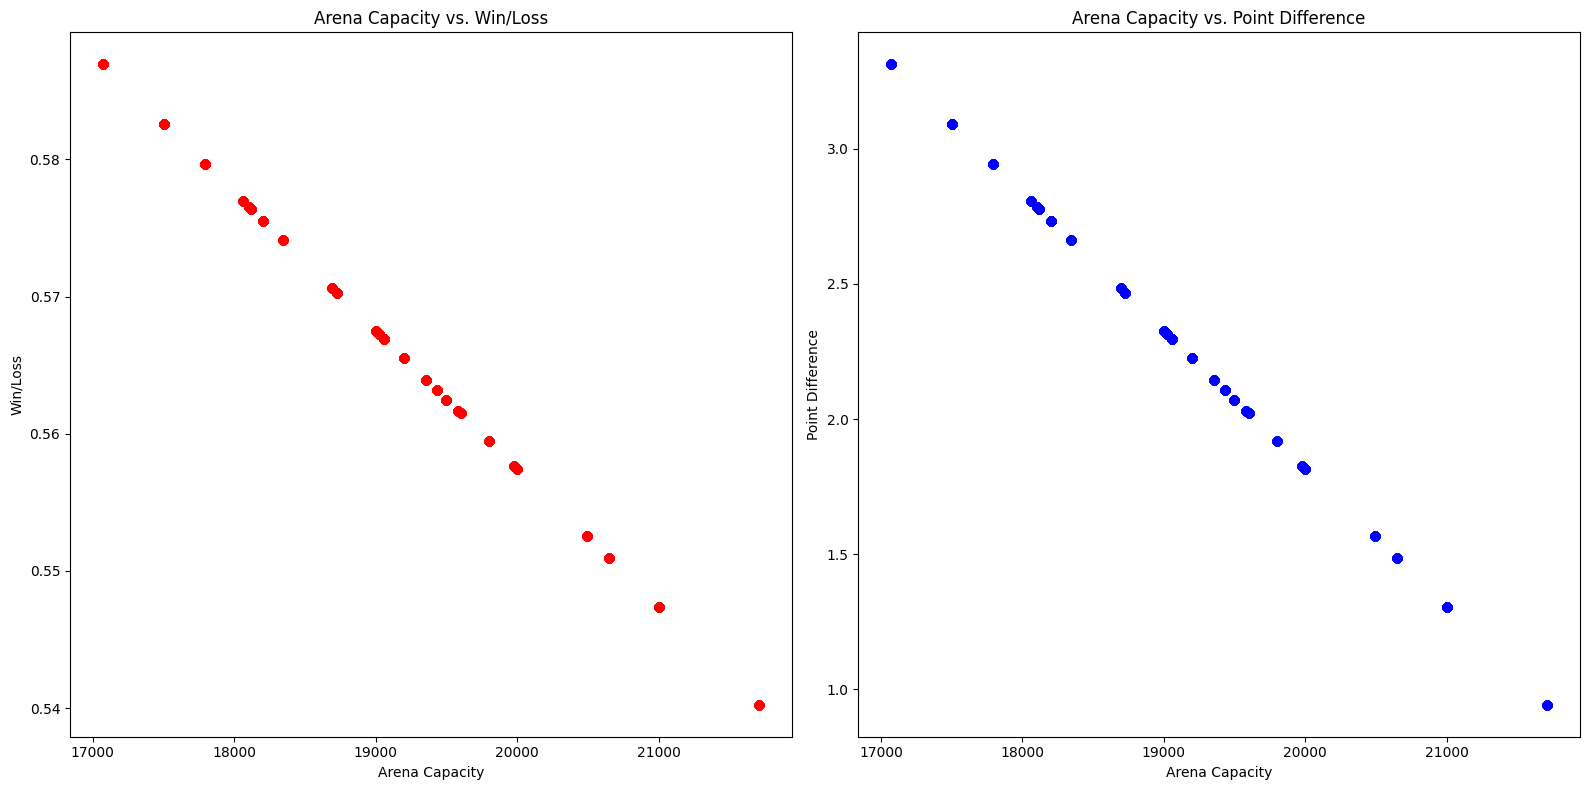

In [27]:
arena_capacity_model = LinearRegressionModel()

arena_capacity = pd.DataFrame(df_filtered["arenacapacity"])

arena_capacity_model.fit(arena_capacity, win_loss)
win_loss_pred = arena_capacity_model.predict(arena_capacity)

f = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.scatter(arena_capacity, win_loss_pred, color="r")
plt.title('Arena Capacity vs. Win/Loss')
plt.xlabel('Arena Capacity')
plt.ylabel('Win/Loss')

arena_capacity_model.fit(arena_capacity, points_difference)
points_difference_pred = arena_capacity_model.predict(arena_capacity)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.scatter(arena_capacity, points_difference_pred, color="b")
plt.title('Arena Capacity vs. Point Difference')
plt.xlabel('Arena Capacity')
plt.ylabel('Point Difference')

plt.tight_layout()
plt.show()

Surprisingly, the univariate model trained on arena capacity shows that the win/loss and point difference could be inversely proportional to the arena capacity!

### Attendance

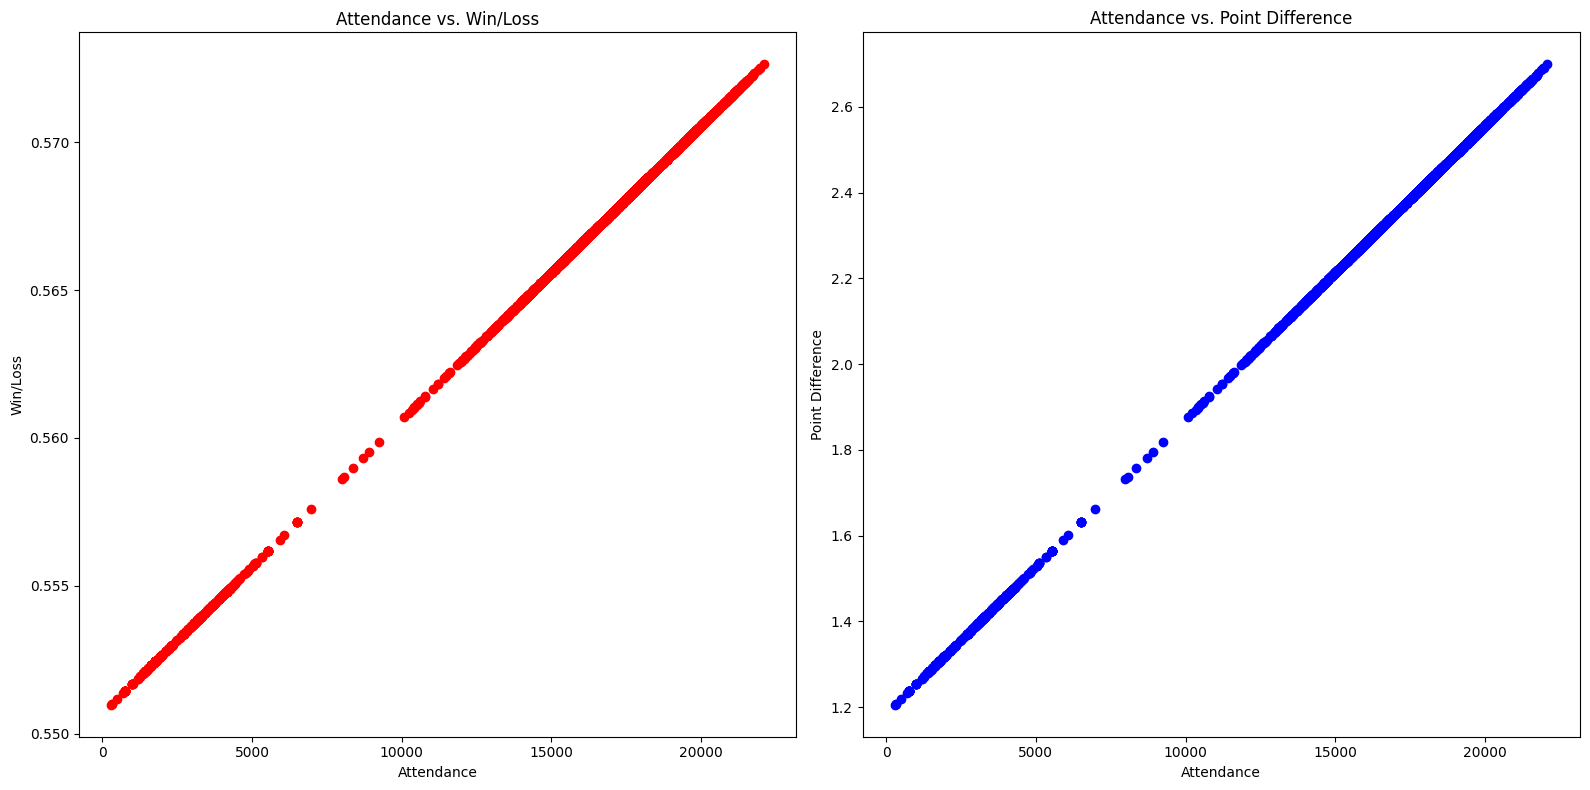

In [28]:
attendance_model = LinearRegressionModel()

attendance = pd.DataFrame(df_filtered["attendance"])

attendance_model.fit(attendance, win_loss)
win_loss_pred = attendance_model.predict(attendance)

f = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(attendance, win_loss_pred, color="r")
plt.title('Attendance vs. Win/Loss')
plt.xlabel('Attendance')
plt.ylabel('Win/Loss')

attendance_model.fit(attendance, points_difference)
points_difference_pred = attendance_model.predict(attendance)

plt.subplot(1, 2, 2)
plt.scatter(attendance, points_difference_pred, color="b")
plt.title('Attendance vs. Point Difference')
plt.xlabel('Attendance')
plt.ylabel('Point Difference')

plt.tight_layout()
plt.show()

Results are more aligned with our predictions. Winning chance decreases ever so slightly when attendance is higher, with point difference increasing in a more significant manner (i.e. teams have about the same winning rate regardless of attendance, but they tend to win bigger with a big crowd!)

### Altitude

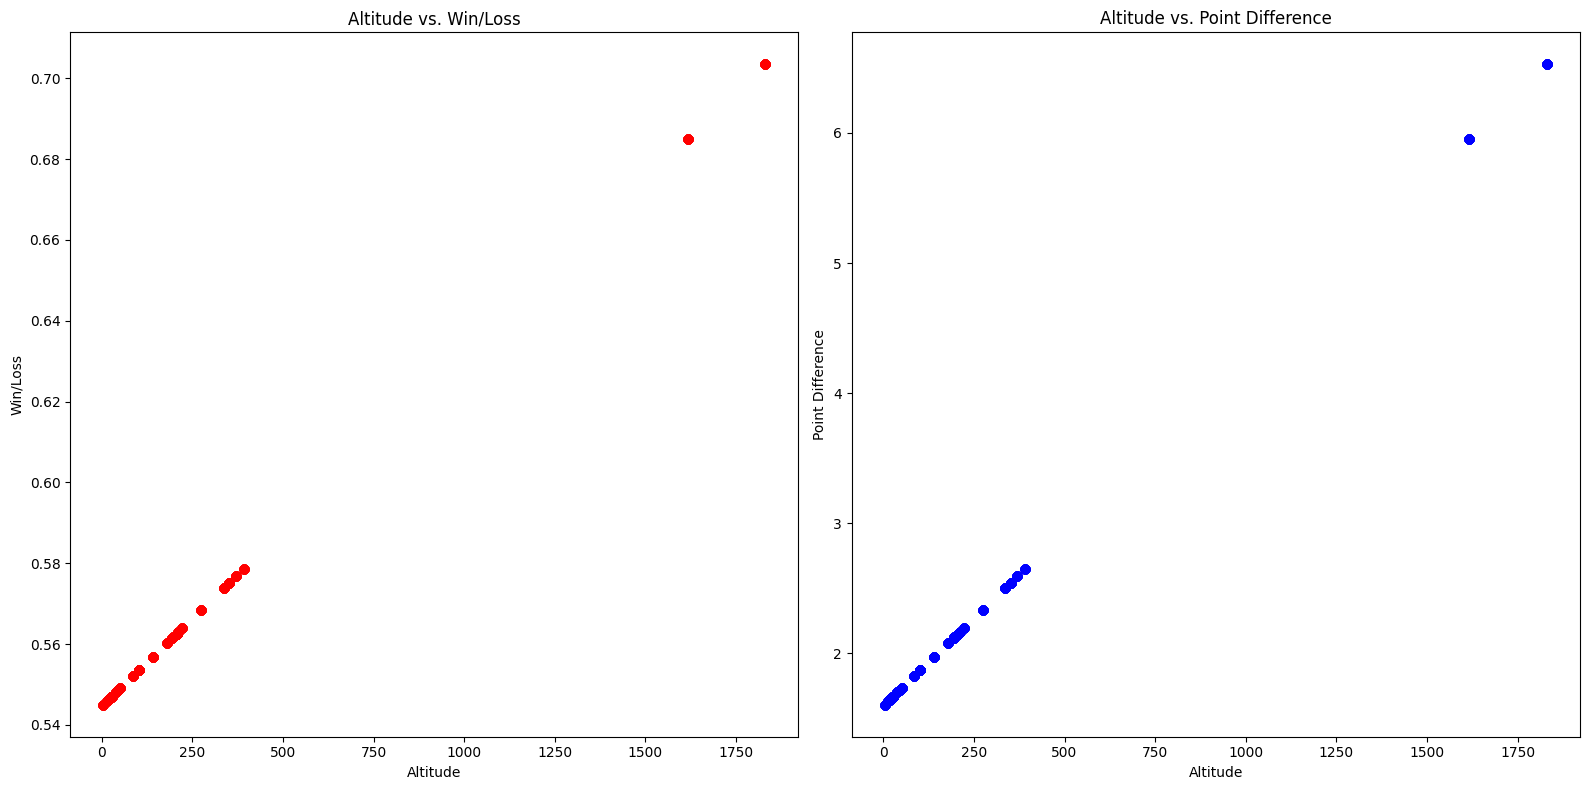

In [29]:
altitude_model = LinearRegressionModel()

altitudes = pd.DataFrame(df_filtered["altitude"])

altitude_model.fit(altitudes, win_loss)
win_loss_pred = altitude_model.predict(altitudes)

f = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(altitudes, win_loss_pred, color="r")
plt.title('Altitude vs. Win/Loss')
plt.xlabel('Altitude')
plt.ylabel('Win/Loss')

altitude_model.fit(altitudes, points_difference)
points_difference_pred = altitude_model.predict(altitudes)

plt.subplot(1, 2, 2)
plt.scatter(altitudes, points_difference_pred, color="b")
plt.title('Altitude vs. Point Difference')
plt.xlabel('Altitude')
plt.ylabel('Point Difference')

plt.tight_layout()
plt.show()

Certainly, there is a noticeable correlation between altitude and its impact on win/loss ratios and point differentials in sports arenas. Nevertheless, it's essential not to hastily attribute causation, as teams in higher altitudes may inherently possess greater strength compared to the average NBA team.

### Travel Distance

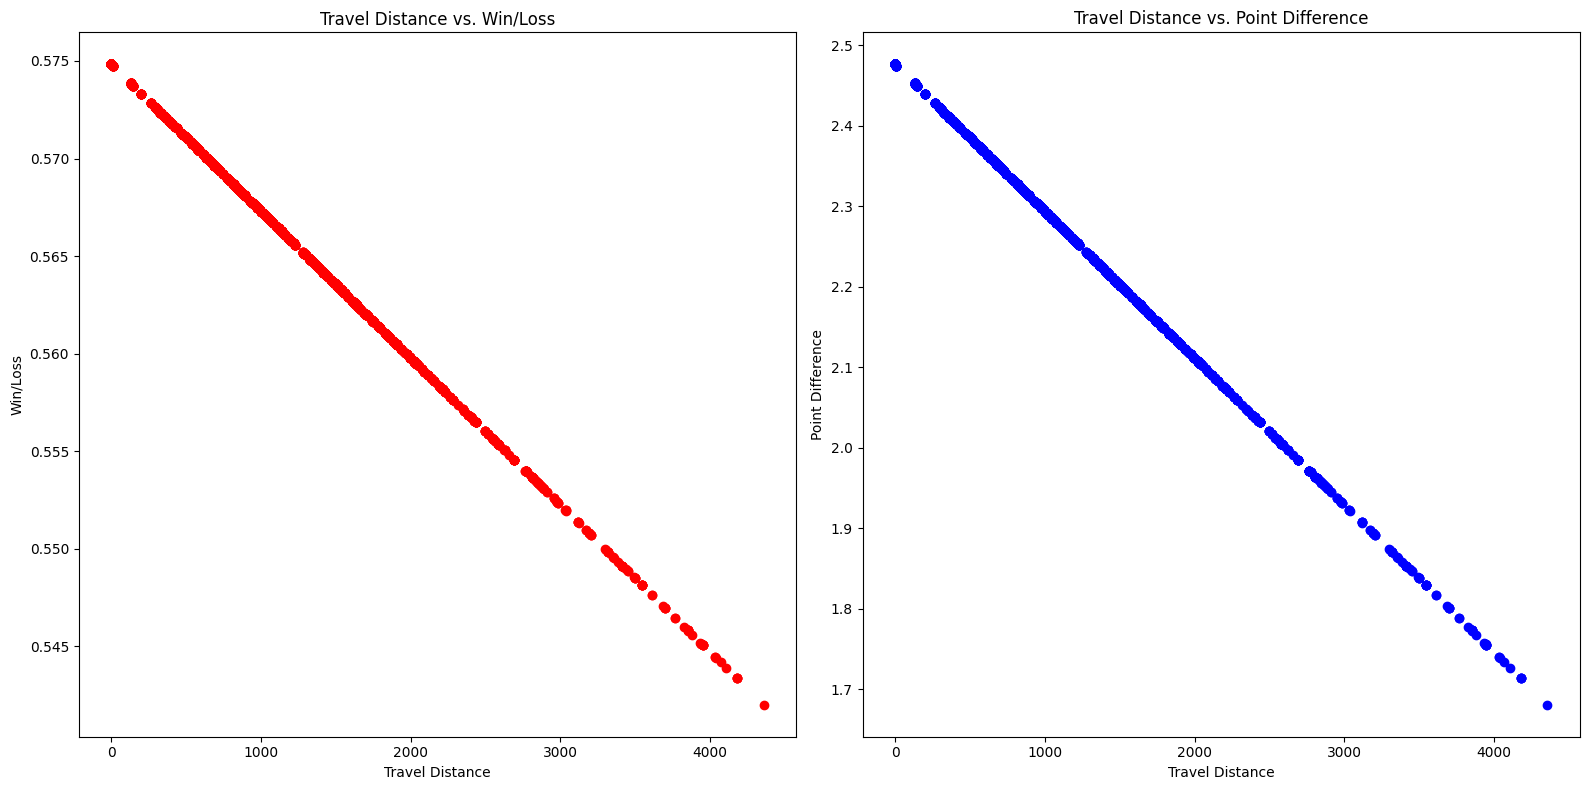

In [30]:
travel_distance_model = LinearRegressionModel()

travel_distances = pd.DataFrame(df_filtered["travel_distance"])

travel_distance_model.fit(travel_distances, win_loss)
win_loss_pred = travel_distance_model.predict(travel_distances)

f = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(travel_distances, win_loss_pred, color="r")
plt.title('Travel Distance vs. Win/Loss')
plt.xlabel('Travel Distance')
plt.ylabel('Win/Loss')

travel_distance_model.fit(travel_distances, points_difference)
points_difference_pred = travel_distance_model.predict(travel_distances)

plt.subplot(1, 2, 2)
plt.scatter(travel_distances, points_difference_pred, color="b")
plt.title('Travel Distance vs. Point Difference')
plt.xlabel('Travel Distance')
plt.ylabel('Point Difference')

plt.tight_layout()
plt.show()

Once more, the outcomes do not align with our initial expectations. However, this may be due to travel distance not being the most reliable factor to account for travel fatigue. (See **Section 5. Future Improvements** for more information)

## Multivariate Analysis

### Multivariate Linear Regression
Now that we have a sensing for how individual variables are related to win/loss and point difference, we will use multi-variate linear regression to hopefully get a more accurate model and test it with 2022-23 data to see the accuracy of our model.

In [36]:
# Split data into train and test by Year

df_train = df_filtered[df_filtered['season_id'].isin([22019, 22020, 22021])]
win_loss_train = df_train['wl_home'].replace({'W': 1, 'L': 0}).astype(int)
points_difference_train = df_train['pts_home'] - df_train['pts_away']

df_test = df_filtered[df_filtered['season_id'].isin([22022])]
win_loss_test = df_test['wl_home'].replace({'W': 1, 'L': 0}).astype(int)
points_difference_test = df_test['pts_home'] - df_test['pts_away']

        Predictors  Coefficients
0    arenacapacity -7.566519e-06
1       attendance  1.034829e-07
2         altitude  1.001560e-04
3  travel_distance -4.090392e-06



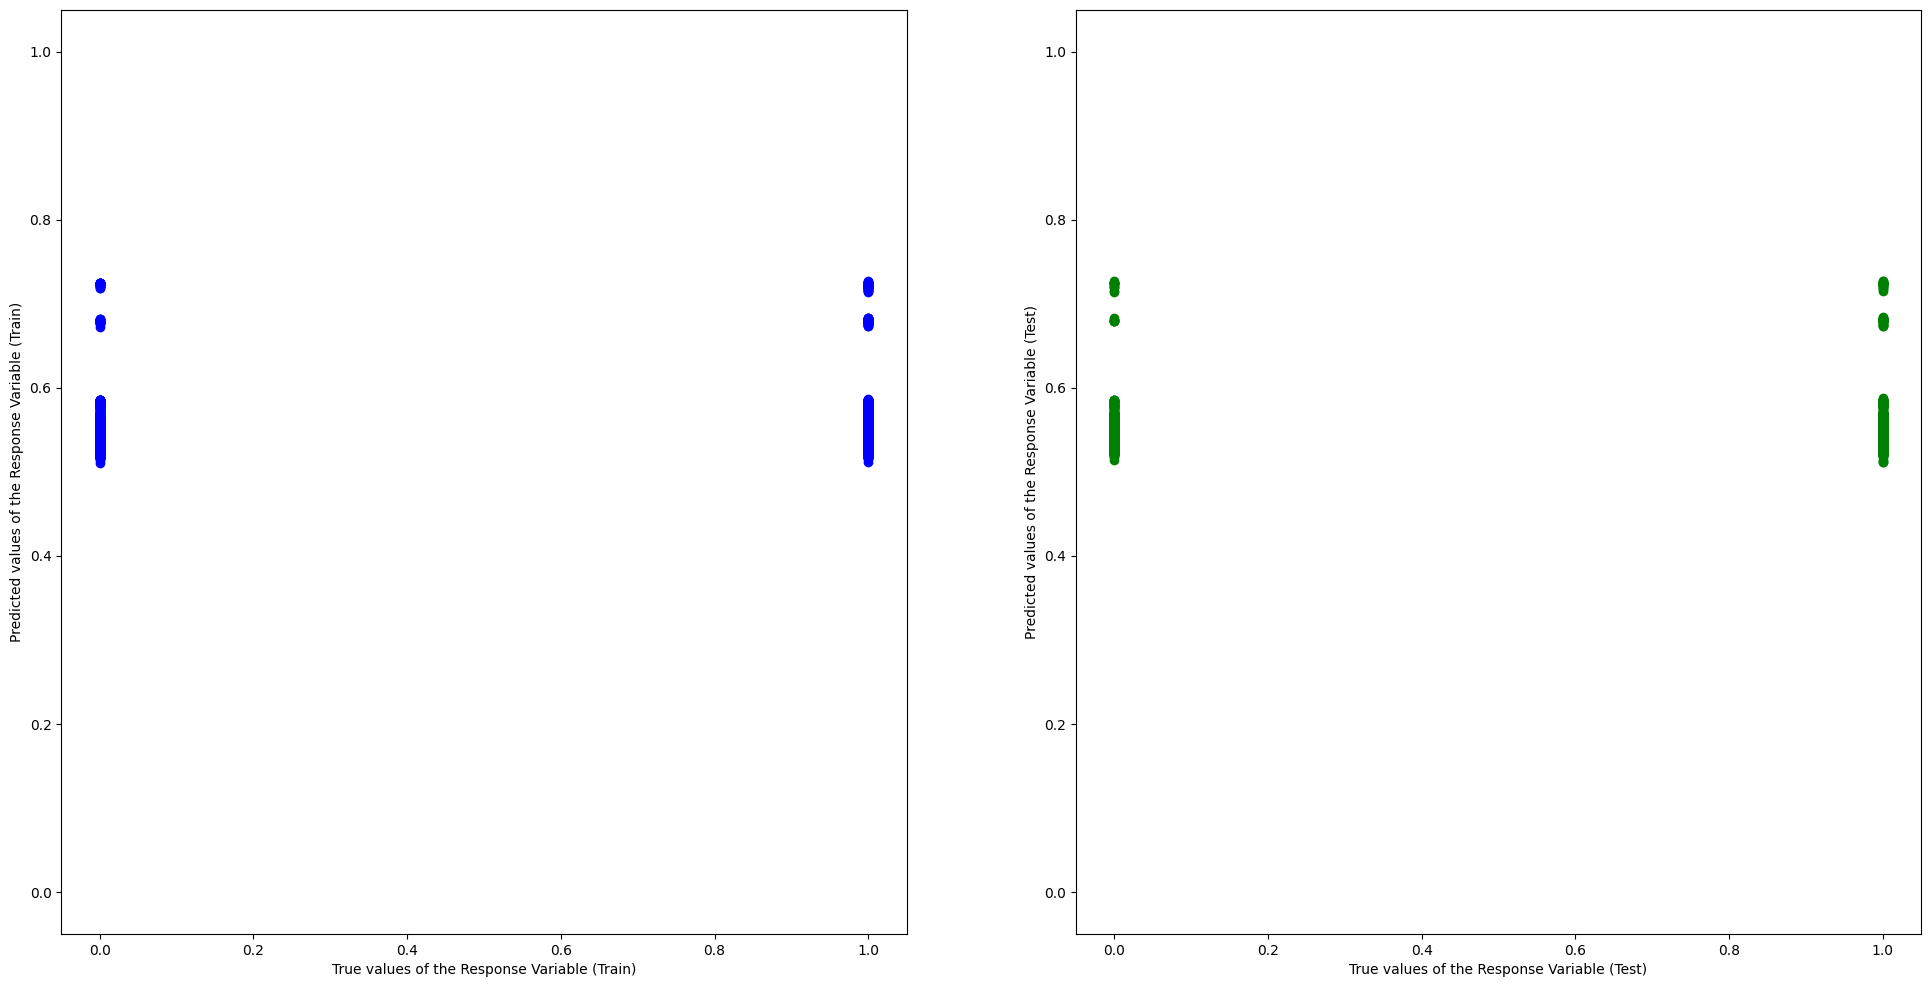

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.007449076401584875
Mean Squared Error (MSE) 	: 0.2448359495262037
Root Mean Squared Error (RMSE) 	: 0.49480900307715064

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.00031276073967601015
Mean Squared Error (MSE) 	: 0.24273561501771615
Root Mean Squared Error (RMSE) 	: 0.49268206281304394



In [46]:
multi_variate_model = LinearRegressionModel()

multi_variables_train = pd.DataFrame(df_train[["arenacapacity", "attendance", "altitude", "travel_distance"]])
multi_variables_test = pd.DataFrame(df_test[["arenacapacity", "attendance", "altitude", "travel_distance"]])

multi_variate_model.fit(multi_variables_train, win_loss_train)

intercept, coefficients = multi_variate_model.details()

print(pd.DataFrame(list(zip(multi_variables.columns, coefficients)), columns = ["Predictors", "Coefficients"]))
print()

# # Predict Response corresponding to Predictors
win_loss_train_pred = multi_variate_model.predict(multi_variables_train)
win_loss_test_pred = multi_variate_model.predict(multi_variables_test)

# # Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(win_loss_train, win_loss_train_pred, color = "blue")
axes[0].plot(win_loss_train, win_loss_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(win_loss_test, win_loss_test_pred, color = "green")
axes[1].plot(win_loss_test, win_loss_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
multi_variate_model.evaluate(multi_variables_train, win_loss_train)
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
multi_variate_model.evaluate(multi_variables_test, win_loss_test)
print()

        Predictors  Coefficients
0    arenacapacity     -0.000659
1       attendance      0.000063
2         altitude      0.003481
3  travel_distance      0.000030



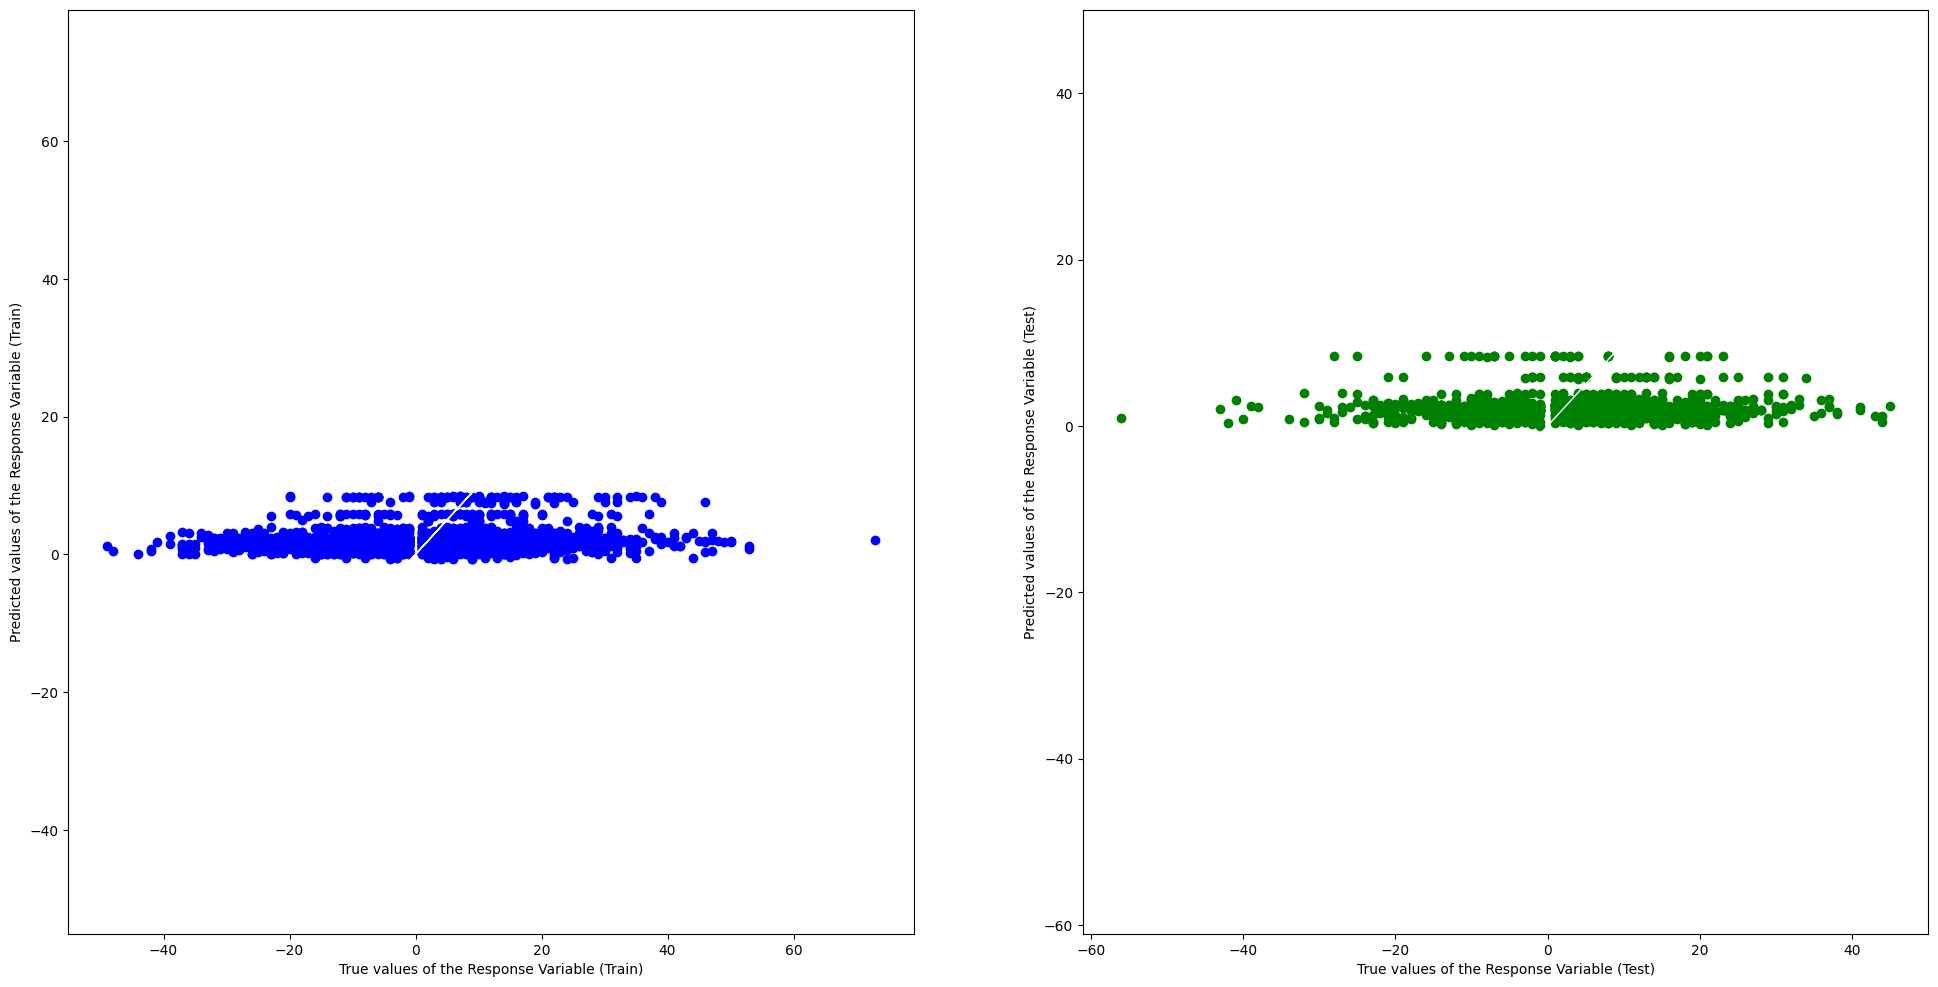

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.011913242482922692
Mean Squared Error (MSE) 	: 222.9359726982315
Root Mean Squared Error (RMSE) 	: 14.931040576538244

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0032565247929032815
Mean Squared Error (MSE) 	: 187.70614412201945
Root Mean Squared Error (RMSE) 	: 13.700589188864086



In [45]:
multi_variate_model = LinearRegressionModel()

multi_variables_train = pd.DataFrame(df_train[["arenacapacity", "attendance", "altitude", "travel_distance"]])
multi_variables_test = pd.DataFrame(df_test[["arenacapacity", "attendance", "altitude", "travel_distance"]])

multi_variate_model.fit(multi_variables_train, points_difference_train)

intercept, coefficients = multi_variate_model.details()

print(pd.DataFrame(list(zip(multi_variables.columns, coefficients)), columns = ["Predictors", "Coefficients"]))
print()

# # Predict Response corresponding to Predictors
points_difference_train_pred = multi_variate_model.predict(multi_variables_train)
points_difference_test_pred = multi_variate_model.predict(multi_variables_test)

# # Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(points_difference_train, points_difference_train_pred, color = "blue")
axes[0].plot(points_difference_train, points_difference_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(points_difference_test, points_difference_test_pred, color = "green")
axes[1].plot(points_difference_test, points_difference_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
multi_variate_model.evaluate(multi_variables_train, points_difference_train)
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
multi_variate_model.evaluate(multi_variables_test, points_difference_test)
print()

Clearly, linear regression is not a good model for this scenario. Let's try other models to predict this behaviour. Furthermore, we will be analyzing points_difference only from now on as the feature has more depth than W/L

### Lasso Model

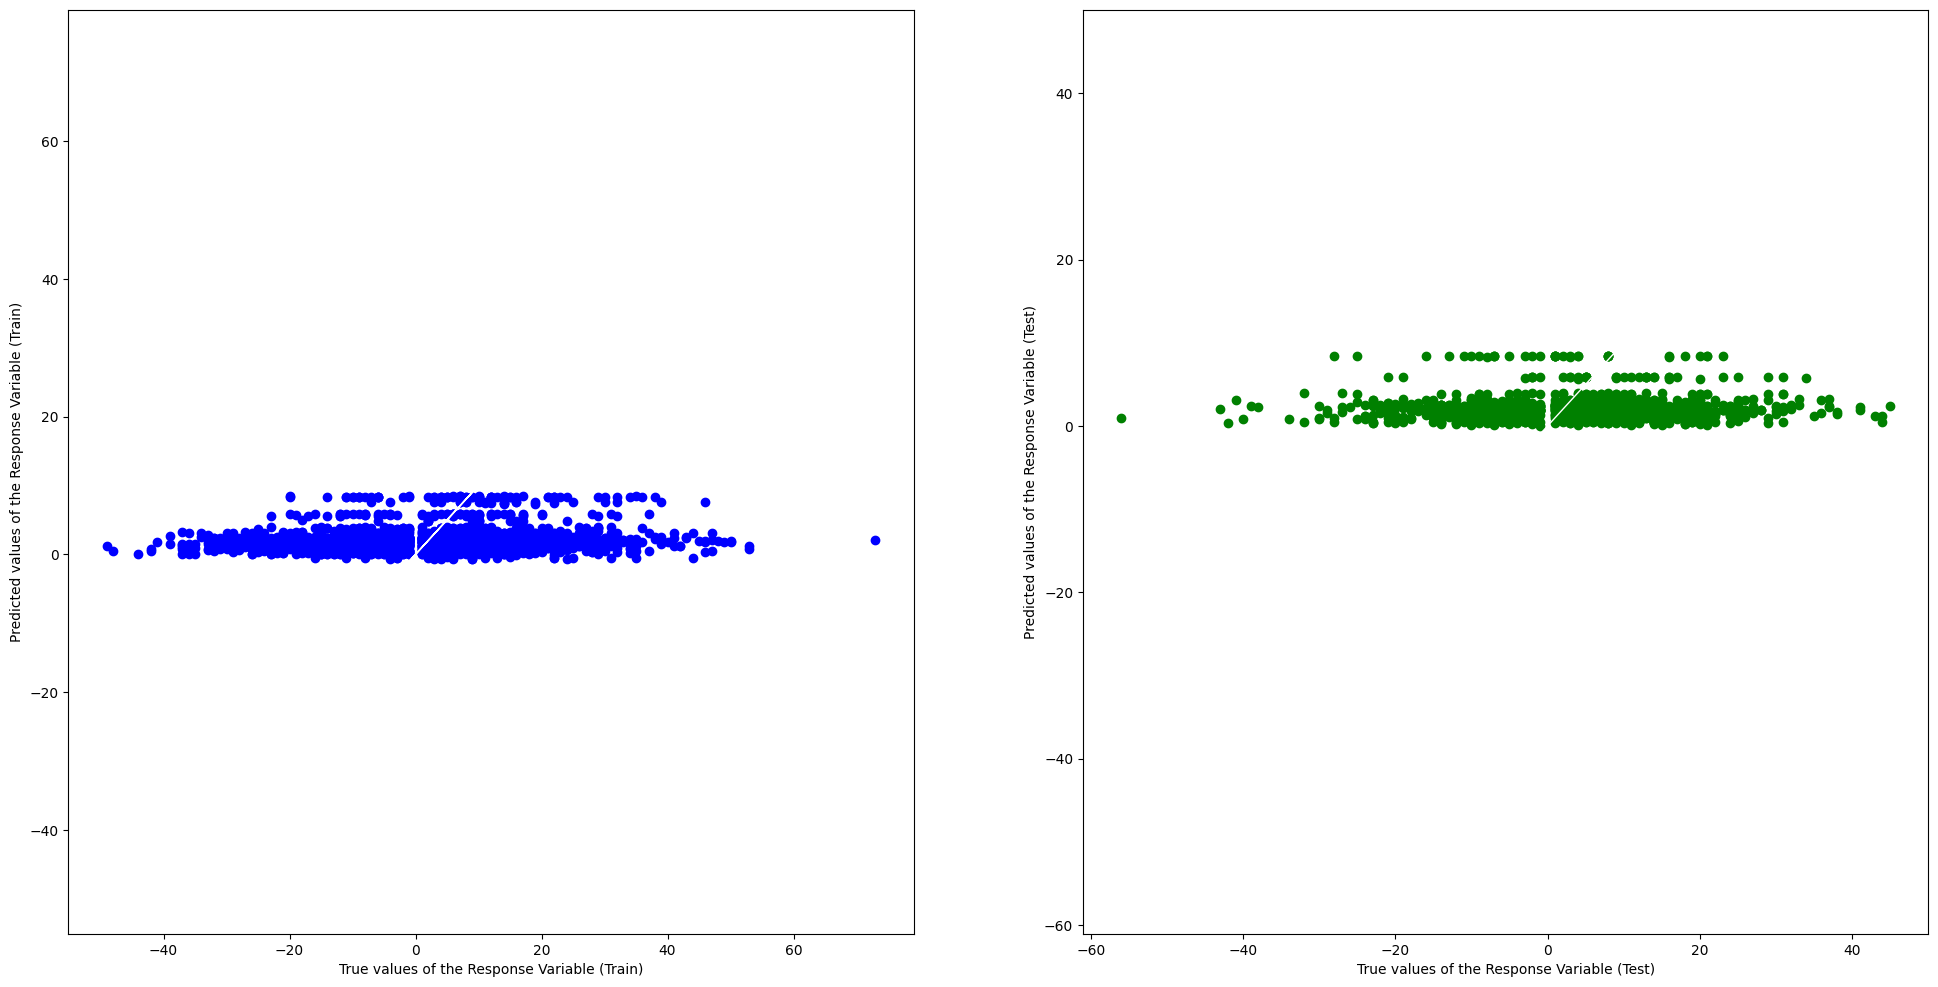

LASSO Model Evaluation on Train Data
0.011913242126763146
LASSO Model Evaluation on Test Data
-0.003253087780676678


In [59]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(multi_variables_train, points_difference_train)

# Predict
points_difference_train_pred_lasso = lasso_model.predict(multi_variables_train)
points_difference_test_pred_lasso = lasso_model.predict(multi_variables_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(points_difference_train, points_difference_train_pred_lasso, color = "blue")
axes[0].plot(points_difference_train, points_difference_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(points_difference_test, points_difference_test_pred_lasso, color = "green")
axes[1].plot(points_difference_test, points_difference_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Evaluate
print("LASSO Model Evaluation on Train Data")
print(lasso_model.score(multi_variables_train, points_difference_train))
print("LASSO Model Evaluation on Test Data")
print(lasso_model.score(multi_variables_test, points_difference_test))

### Ridge Model

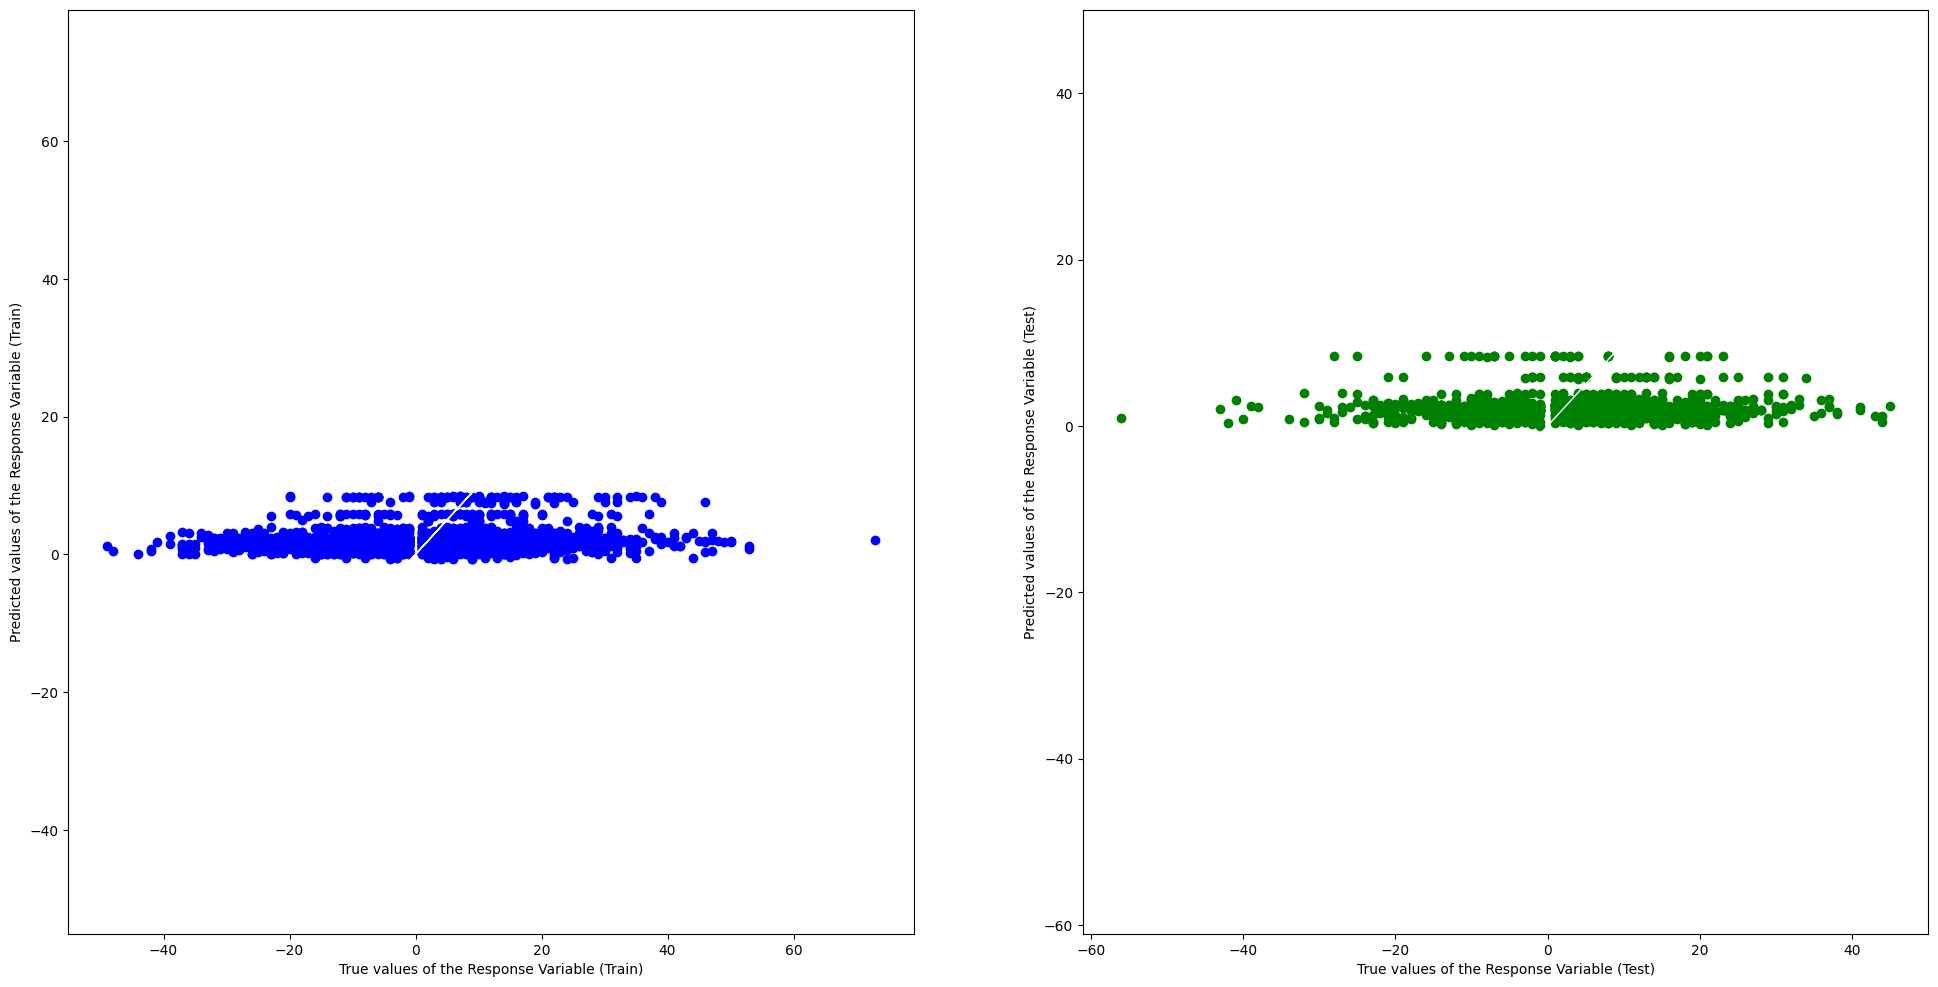

Ridge Model Evaluation on Train Data
0.011913242482922914
Ridge Model Evaluation on Test Data
-0.003256524789425841


In [60]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(multi_variables_train, points_difference_train)

# Predict
points_difference_train_pred_ridge = ridge_model.predict(multi_variables_train)
points_difference_test_pred_ridge = ridge_model.predict(multi_variables_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(points_difference_train, points_difference_train_pred_ridge, color = "blue")
axes[0].plot(points_difference_train, points_difference_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(points_difference_test, points_difference_test_pred_ridge, color = "green")
axes[1].plot(points_difference_test, points_difference_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Evaluate
print("Ridge Model Evaluation on Train Data")
print(ridge_model.score(multi_variables_train, points_difference_train))
print("Ridge Model Evaluation on Test Data")
print(ridge_model.score(multi_variables_test, points_difference_test))

### Random Forest

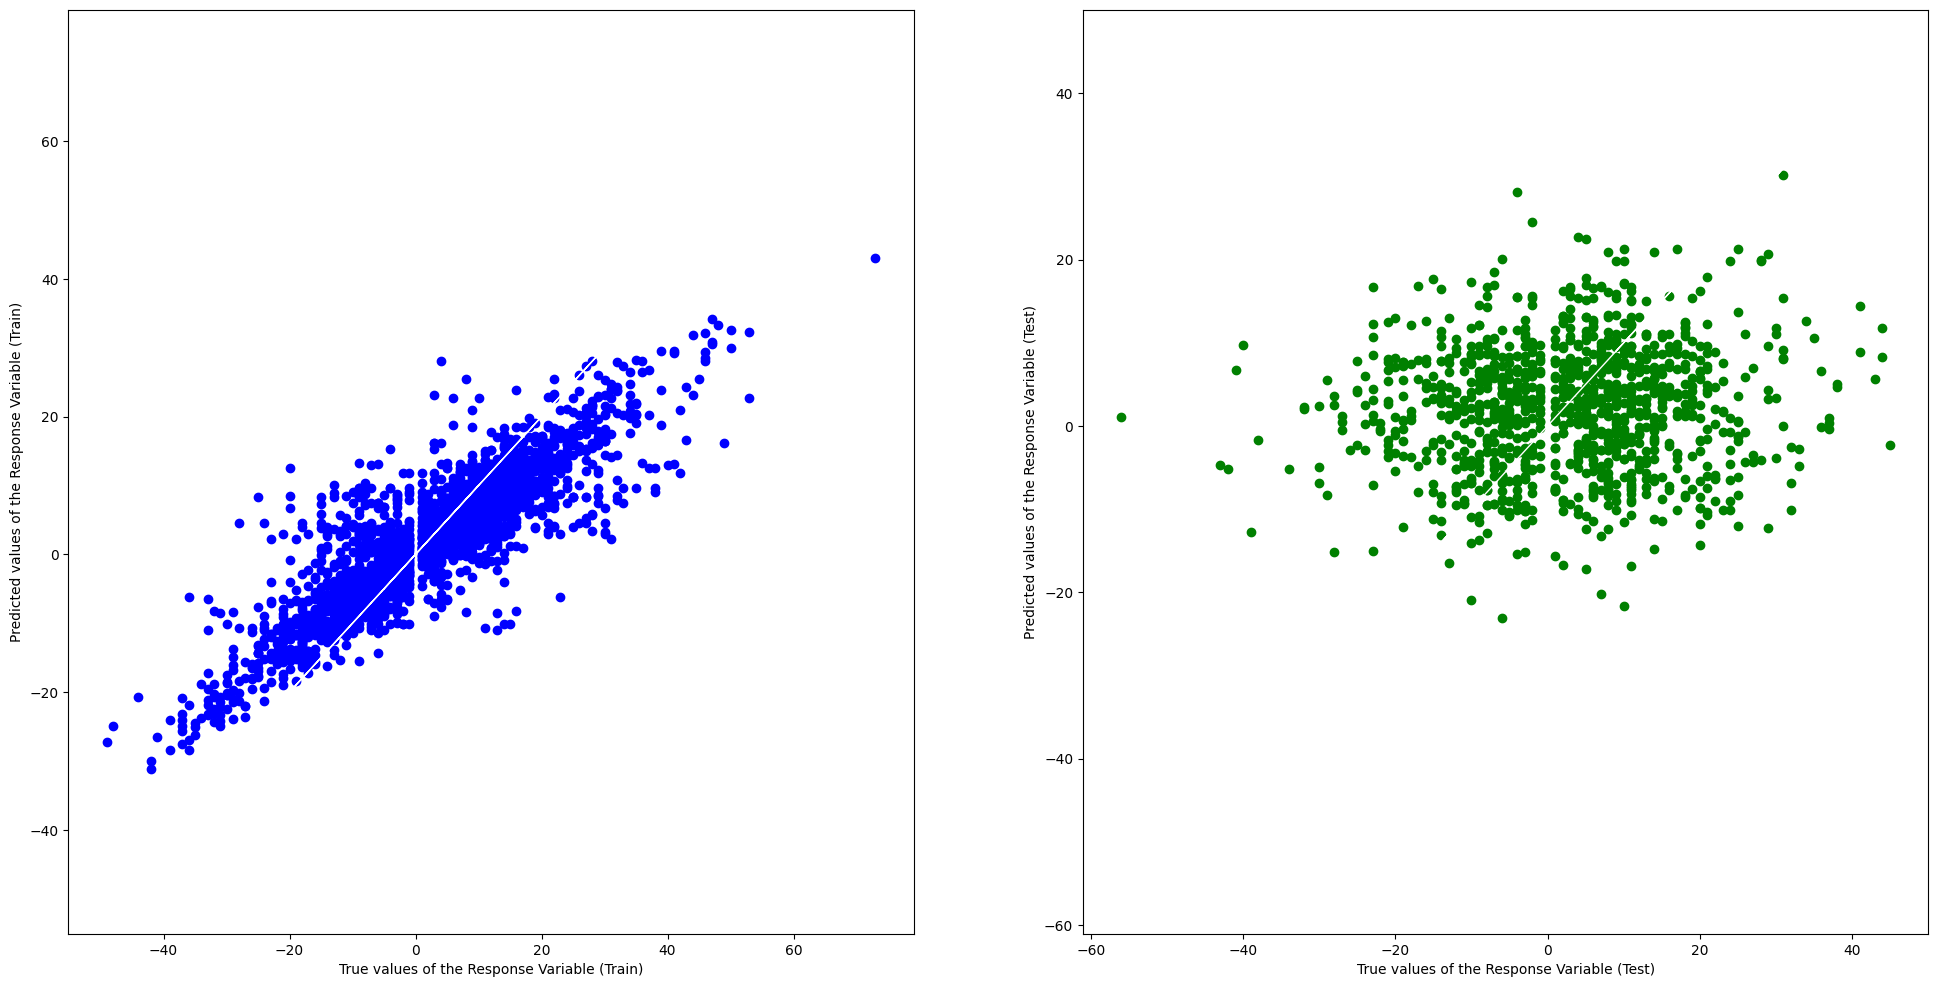

Random Forest Model Evaluation on Train Data
0.7182499125432527
Random Forest Model Evaluation on Test Data
-0.2111947779716501


In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(multi_variables_train, points_difference_train)

# Predict
points_difference_train_pred_rf = rf_model.predict(multi_variables_train)
points_difference_test_pred_rf = rf_model.predict(multi_variables_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(points_difference_train, points_difference_train_pred_rf, color = "blue")
axes[0].plot(points_difference_train, points_difference_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(points_difference_test, points_difference_test_pred_rf, color = "green")
axes[1].plot(points_difference_test, points_difference_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Evaluate
print("Random Forest Model Evaluation on Train Data")
print(rf_model.score(multi_variables_train, points_difference_train))
print("Random Forest Model Evaluation on Test Data")
print(rf_model.score(multi_variables_test, points_difference_test))

### Gradient Boosting Regressor

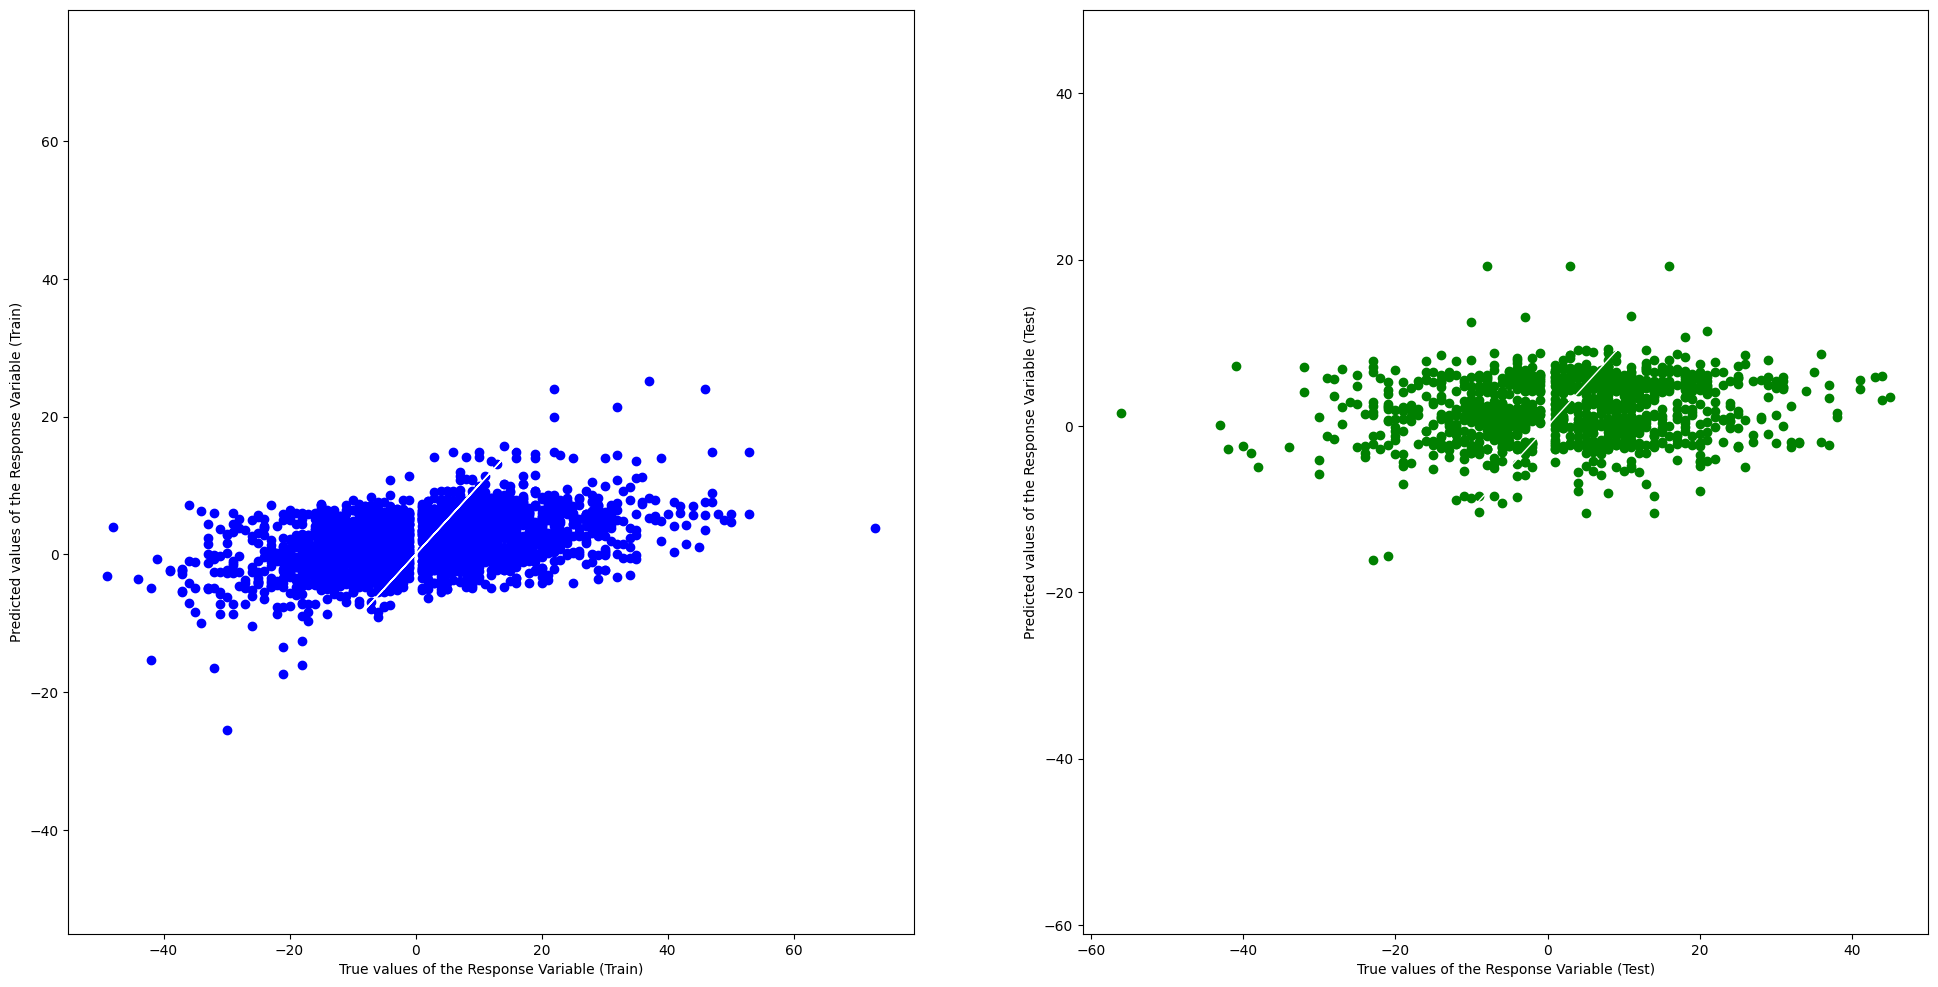

Gradient Boosting Model Evaluation on Train Data
0.1680487385099908
Gradient Boosting Model Evaluation on Test Data
0.008993445293744351


In [62]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gb_model.fit(multi_variables_train, points_difference_train)

# Predict
points_difference_train_pred_gb = gb_model.predict(multi_variables_train)
points_difference_test_pred_gb = gb_model.predict(multi_variables_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(points_difference_train, points_difference_train_pred_gb, color = "blue")
axes[0].plot(points_difference_train, points_difference_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(points_difference_test, points_difference_test_pred_gb, color = "green")
axes[1].plot(points_difference_test, points_difference_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Evaluate
print("Gradient Boosting Model Evaluation on Train Data")
print(gb_model.score(multi_variables_train, points_difference_train))
print("Gradient Boosting Model Evaluation on Test Data")
print(gb_model.score(multi_variables_test, points_difference_test))

# Section 5: Discussion of Results

## Insights from Trained Models

We see poor results from almost all the models, which suggests that the factors identified, although clearly playing a role in the W/L and points difference in teams playing at home and in their opponent's court, do not have as significant an impact as other factors on the measured parameters. Interestingly, the random forest model managed to learn and predict quite well from the train data, which supports the strengths of a random forest model (high dimensionality and robustness to outliers). 

The good fit in the random forest model, along with the poor fit in the other models, suggests strongly that the variables that we have selected has a non-linear relationship with the factors that we are basing home court advantage on.

## Future Improvements

We can improve the quality of our input data. For instance, estimations for travel fatigue can be significantly improved by gathering more specific arena location data and factoring in the travel distances between airports and arenas. These provide a more realistic picture of the athletes' journeys. Secondly, it's important to acknowledge the travel burden placed on the home team when they return from an away game.

While we chose to omit officiating bias from our current analysis, we recognize its potential impact on game outcomes. A future study could provide valuable insights by examining the discrepancies between fouls called against home teams versus away teams. This analysis, while not a definitive measure of referee bias, could highlight potential areas of concern and offer a starting point for further investigation.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cc79298-9a58-44b5-aa02-4897a1696bab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>